# Content

In this notebook we run our algorithm to distinguish the classes of the SP data. Each point represents two classes and andone day. The pipeline goes as follows

* We first load the data from the `SP_Classes_2_per_day` folder
* We then generate the embeddings
* For visualization porpuses we plot the embeddings in 2 dimensions using *TSNE* algorithm
* Finally, we run a random tree classifier on the embeddings to reconstruct the classes assignment. We to this multiple times using 70% of the dataset as training set and the remaining 30% as train set.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from collections import Counter

import sys
sys.path += ['/home/lorenzo/Scrivania/My_projects/Embeddings/02_GraphD/Dynamic_distance/Codes/Package']

from MatrixDistance import *

import warnings
warnings.filterwarnings("ignore")

In [4]:
# # load the data
# ROOT = 'Data/SP_Classes_2_per_day/'
# all_files = listdir(ROOT)

# n = len(all_files)
# gt = [x.split('-')[0] for x in all_files]

# DFT = []

# for file in all_files:
#     DFT.append(pd.read_csv(ROOT + file))
    
# school = np.array([x.split('-')[0] for x in all_files])
# classes = np.array([x.split('-')[1] for x in all_files])
    
# # generate the embeddings
# λlist = []

# for i in range(n):
#     # print progress
#     print(str(i+1) + '/' + str(n), end = '\r')
    
#     X = GraphDynamicEmbedding(DFT[i], dim = 32)
#     λlist.append(np.linalg.eigvalsh(X.T@X))

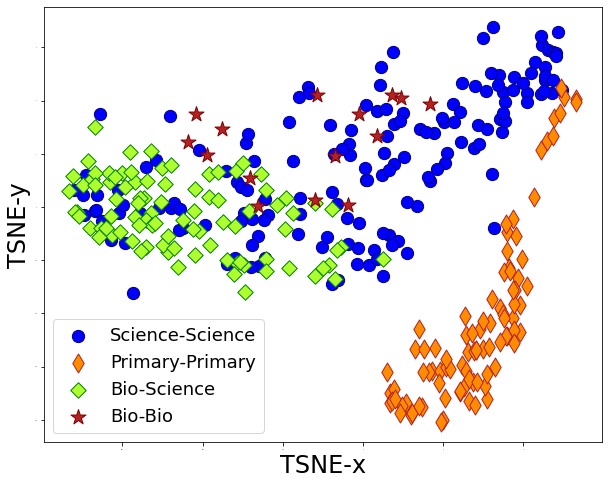

In [10]:
classes1 = [x.split('_')[0] for x in classes]
classes2 = [x.split('_')[1] for x in classes]

ClassMapper = {'1A': 0, '1B': 0, '2A': 0, '2B': 0,
'2BIO1': 1, '2BIO2': 1, '2BIO3': 1, '3A': 0,
'3B': 0, '4A': 0, '4B': 0, '5A': 0,
'5B': 0, 'MP': 2, 'MP*1': 2, 'MP*2': 2, 
'PC': 2, 'PC*': 2, 'PSI*': 2}

cl = [tuple([ClassMapper[x], ClassMapper[y]]) for x, y in zip(classes1, classes2)]

all_classes = list(Counter(cl).keys())

MapperNames = {0: 'Primary', 1: 'Bio', 2: 'Science'}

from sklearn.manifold import TSNE
markers = ['o', 'd', 'D', '*', 's']
colors = ['blue', 'darkorange', 'greenyellow', 'firebrick', 'pink']
edgecolors = ['navy', 'firebrick', 'green', 'maroon', 'indigo']
sizes = [150, 180, 120, 250, 200]

Λ = np.array(λlist)
X_embedded = TSNE(n_components = 2, learning_rate='auto', init='pca', perplexity = 60).fit_transform(Λ)

school = np.array([x.split('-')[0] for x in all_files])
schools = np.unique(school)

plt.figure(figsize = (10, 8))


for i, s in enumerate(all_classes):
    idx = np.array([x == s for x in cl])
    plt.scatter(X_embedded[:,0][idx], X_embedded[:,1][idx], marker = markers[i], 
                      edgecolor = edgecolors[i], s = sizes[i], color = colors[i], label = MapperNames[s[0]] + '-' + MapperNames[s[1]])
    
plt.legend(fontsize = 18)
plt.xticks(fontsize = 0)
plt.yticks(fontsize = 0)
plt.xlabel('TSNE-x', fontsize = 24)
plt.ylabel('TSNE-y', fontsize = 24)
    
plt.savefig('../Figures/school.jpg')
plt.show();

In [4]:
from sklearn import tree

label = np.array([x[0] + 3*x[1] for x in cl])
k = len(np.unique(label))
labelMapper = dict(zip(np.sort(np.unique(label)), np.arange(k)))
label = np.array([labelMapper[x] for x in label])


n_trials = 100

F1 = []
p = 0.7

for counter in range(n_trials):

    idx = np.random.binomial(1, p, n) == 1

    clf = tree.DecisionTreeClassifier().fit(Λ[idx], label[idx])
    predict = clf.predict(Λ[~idx])

    gt = label[~idx]


    CM = np.zeros((k,k))

    for i in range(len(predict)):
        CM[gt[i], predict[i]] += 1

    sP = np.sum(CM, axis = 1)
    sN = np.sum(CM, axis = 0)

    precision = np.diag(CM)/(sP + 0.001)
    recall = np.diag(CM)/(sN + 0.001)

    names = ['Primary-Primary', 'Bio-Bio', 'Bio-Science', 'Science-Science']
    F1.append(2*(precision * recall)/(0.001 + precision + recall))

F1_m = np.mean(F1, axis = 0)
F1_s = np.std(F1, axis = 0)

for i, name in enumerate(names):
    print(name + ': ' + str(np.round(F1_m[i], 2)) + ' ± ' + str(np.round(F1_s[i],2)))



Primary-Primary: 0.96 ± 0.03
Bio-Bio: 0.19 ± 0.16
Bio-Science: 0.62 ± 0.07
Science-Science: 0.72 ± 0.06


In [5]:
CreateEmbedding?